# Kaggle Competition : Microsoft Malware Data
> This is a Sungryong Hong's Notebook.  

> I have a stand-alone Spark(2.3.2)/Hadoop(2.8.3) cluster, which has 48 logical cores with 150GB memory. 

> I have put the data files to my hdfs. Check the contents as `hfs -cat /data/spark/msmalware/test.csv | head`.  

>`hfs` is an alias for `hdfs dfs`. 



## 1. Import Basic Packages

In [1]:
# Basic Libraries 
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import gc

pd.set_option('display.max_rows', 500)

# plot settings
plt.rc('font', family='serif') 
plt.rc('font', serif='Times New Roman') 
plt.rcParams.update({'font.size': 16})
plt.rcParams['mathtext.fontset'] = 'stix'

#### Spark-Shell Sesssion 

In [2]:
# Basic PySpark Libraries

# Old Style : SparkContext 
#from pyspark import SparkContext   
#from pyspark.sql import SQLContext


# New Style : Spark Session  
#Shell-Mode: Spark Session Name is `spark`

sc = spark.sparkContext
sqlsc = SQLContext(sc)
sc.setCheckpointDir("hdfs://master:54310/tmp/spark/checkpoints")

import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark import Row
from pyspark.sql.window import Window as W

In [3]:
# Enable Arrow for boosting up python performances 
spark.conf.set("spark.sql.execution.arrow.enabled", "true")
spark.conf.set('spark.debug.maxToStringFields',50)

## 2. Read `mldata`

In [4]:
import pyarrow as pa
import pyarrow.parquet as pq

In [5]:
mldata = sqlsc.read.parquet('hdfs://master:54310/data/spark/msmalware/mldata.parquet.snappy')

In [6]:
print mldata.columns

['MachineIdentifier', 'HasDetections', 'IsBeta', 'IsSxsPassiveMode', 'HasTpm', 'CountryIdentifier', 'LocaleEnglishNameIdentifier', 'OsBuild', 'OsSuite', 'AutoSampleOptIn', 'Census_HasOpticalDiskDrive', 'Census_OSBuildNumber', 'Census_OSBuildRevision', 'Census_OSUILocaleIdentifier', 'Census_IsPortableOperatingSystem', 'Census_IsSecureBootEnabled', 'Census_IsTouchEnabled', 'Census_IsPenCapable', 'ProductName_indexed_onehot', 'EngineVersion_indexed_onehot', 'AppVersion_indexed_onehot', 'AvSigVersion_indexed_onehot', 'RtpStateBitfield_indexed_onehot', 'DefaultBrowsersIdentifier_indexed_onehot', 'AVProductStatesIdentifier_indexed_onehot', 'AVProductsInstalled_indexed_onehot', 'AVProductsEnabled_indexed_onehot', 'CityIdentifier_indexed_onehot', 'OrganizationIdentifier_indexed_onehot', 'GeoNameIdentifier_indexed_onehot', 'Platform_indexed_onehot', 'Processor_indexed_onehot', 'OsVer_indexed_onehot', 'OsPlatformSubRelease_indexed_onehot', 'OsBuildLab_indexed_onehot', 'SkuEdition_indexed_onehot'

In [7]:
len(mldata.columns)

84

## 4. Run MLs

In [8]:
mldata.select('features').show(5)

+--------------------+
|            features|
+--------------------+
|(383217,[2,3,4,5,...|
|(383217,[2,3,4,5,...|
|(383217,[2,3,4,5,...|
|(383217,[2,3,4,5,...|
|(383217,[2,3,4,5,...|
+--------------------+
only showing top 5 rows



#### Tiny Sample

In [9]:
%%time
mltiny = mldata.sample(False,0.01,seed=777)

CPU times: user 1.22 ms, sys: 892 µs, total: 2.12 ms
Wall time: 27.1 ms


In [10]:
mltiny.cache()

DataFrame[MachineIdentifier: string, HasDetections: int, IsBeta: int, IsSxsPassiveMode: int, HasTpm: int, CountryIdentifier: int, LocaleEnglishNameIdentifier: int, OsBuild: int, OsSuite: int, AutoSampleOptIn: int, Census_HasOpticalDiskDrive: int, Census_OSBuildNumber: int, Census_OSBuildRevision: int, Census_OSUILocaleIdentifier: int, Census_IsPortableOperatingSystem: int, Census_IsSecureBootEnabled: int, Census_IsTouchEnabled: int, Census_IsPenCapable: int, ProductName_indexed_onehot: vector, EngineVersion_indexed_onehot: vector, AppVersion_indexed_onehot: vector, AvSigVersion_indexed_onehot: vector, RtpStateBitfield_indexed_onehot: vector, DefaultBrowsersIdentifier_indexed_onehot: vector, AVProductStatesIdentifier_indexed_onehot: vector, AVProductsInstalled_indexed_onehot: vector, AVProductsEnabled_indexed_onehot: vector, CityIdentifier_indexed_onehot: vector, OrganizationIdentifier_indexed_onehot: vector, GeoNameIdentifier_indexed_onehot: vector, Platform_indexed_onehot: vector, Pro

In [11]:
%%time
mltiny.count()

CPU times: user 14.3 ms, sys: 7.32 ms, total: 21.7 ms
Wall time: 1min 21s


89524

In [12]:
mltiny.select('features').show(5)

+--------------------+
|            features|
+--------------------+
|(383217,[2,3,4,5,...|
|(383217,[2,3,4,5,...|
|(383217,[2,3,4,5,...|
|(383217,[2,3,4,5,...|
|(383217,[2,3,4,5,...|
+--------------------+
only showing top 5 rows



#### Small Sample

In [13]:
%%time
mlsmall = mldata.sample(False,0.1,seed=888)

CPU times: user 718 µs, sys: 942 µs, total: 1.66 ms
Wall time: 14 ms


In [14]:
%%time
mlsmall.count()

CPU times: user 1.78 ms, sys: 1.22 ms, total: 3 ms
Wall time: 4.41 s


892289

### 4.1 Trying `LightGBM` from mmlspark

> Website : https://github.com/Azure/mmlspark/blob/master/docs/lightgbm.md

In [15]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator as BCE

In [16]:
from mmlspark import LightGBMClassifier

In [17]:
gbclassifier = LightGBMClassifier(learningRate=0.3, numIterations=100,\
                                  #earlyStoppingRound=10,\
                                  labelCol='HasDetections',featuresCol='features')

In [18]:
paramGrid = ParamGridBuilder().addGrid(gbclassifier.numLeaves, [10, 20, 40]).build()
gbeval = BCE(labelCol='HasDetections',metricName='areaUnderROC')

In [19]:
gbcrossval = CrossValidator(estimator=gbclassifier, estimatorParamMaps=paramGrid,\
                            evaluator=gbeval,numFolds=4) 

#### For `mltiny`

In [20]:
%%time
gbcvmodeltiny  = gbcrossval.fit(mltiny)

CPU times: user 2.23 s, sys: 709 ms, total: 2.94 s
Wall time: 36min 27s


In [21]:
print("trained LightGBM :%s" % gbcvmodeltiny) #using the best model among cross-validation folds 

trained LightGBM :CrossValidatorModel_48ecbaa6fdb9e45ffffe


In [22]:
gbcvmodeltiny.avgMetrics

[0.6959030040681967, 0.6937940104849806, 0.6889281679346217]

In [23]:
# display CV score
auc_roc = gbcvmodeltiny.avgMetrics[0]
print("AUC ROC = %g" % auc_roc)
gini = (2 * auc_roc - 1)
print("GINI ~=%g" % gini)

AUC ROC = 0.695903
GINI ~=0.391806


### 4.2 Trying `RandomForestClassifer` from Spark ML

In [24]:
from pyspark.ml.classification import RandomForestClassifier

In [25]:
rfclassifier = RandomForestClassifier(labelCol='HasDetections',featuresCol='features')

In [26]:
rfparamGrid = ParamGridBuilder().addGrid(rfclassifier.numTrees, [10, 30, 60]).build()
rfeval = BCE(labelCol='HasDetections',metricName='areaUnderROC')

In [27]:
rfcrossval = CrossValidator(estimator=rfclassifier, estimatorParamMaps=rfparamGrid,\
                            evaluator=rfeval,numFolds=4) 

#### For `mltiny`

In [28]:
%%time
rfcvmodeltiny  = rfcrossval.fit(mltiny)

CPU times: user 13.5 s, sys: 6.62 s, total: 20.1 s
Wall time: 2h 42min 39s


In [29]:
rfcvmodeltiny.avgMetrics

[0.5626379922764235, 0.5775515335142796, 0.611050824305375]

> Is `lightGBM` too good ? 

### 4.3 Feature Importance 

> `LightGBM` from `mmlspark` showed some error messages when getting feautre importances from   `model.getFeatureImportances()`. So, Let's check out the available feature importances from `RandomForestClassifier`. 

In [30]:
# Covert the Vector-assembled feature importances to human-readables 
def ExtractFeatureImportance(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

#### Random Forest 

In [31]:
rfFeatureImportance = ExtractFeatureImportance(rfcvmodeltiny.bestModel.featureImportances,mltiny,'features')

In [32]:
rfFeatureImportance.head(10)

,idx,name,score
148486,148502,SmartScreen_indexed_onehot_RequireAdmin,0.031476
148526,148542,Census_MDC2FormFactor_indexed_onehot_LargeTablet,0.022672
148181,148197,SMode_indexed_onehot_0,0.022113
331317,331333,Census_OSVersion_indexed_onehot_10.0.17134.165,0.019637
39712,39728,AVProductsInstalled_indexed_onehot_2,0.018671
10764,10780,AVProductStatesIdentifier_indexed_onehot_11280,0.018588
39720,39736,AVProductsEnabled_indexed_onehot_2,0.018173
148521,148537,Census_MDC2FormFactor_indexed_onehot_Desktop,0.016051
147436,147452,Processor_indexed_onehot_x64,0.014958
9,25,EngineVersion_indexed_onehot_1.1.14901.4,0.012911


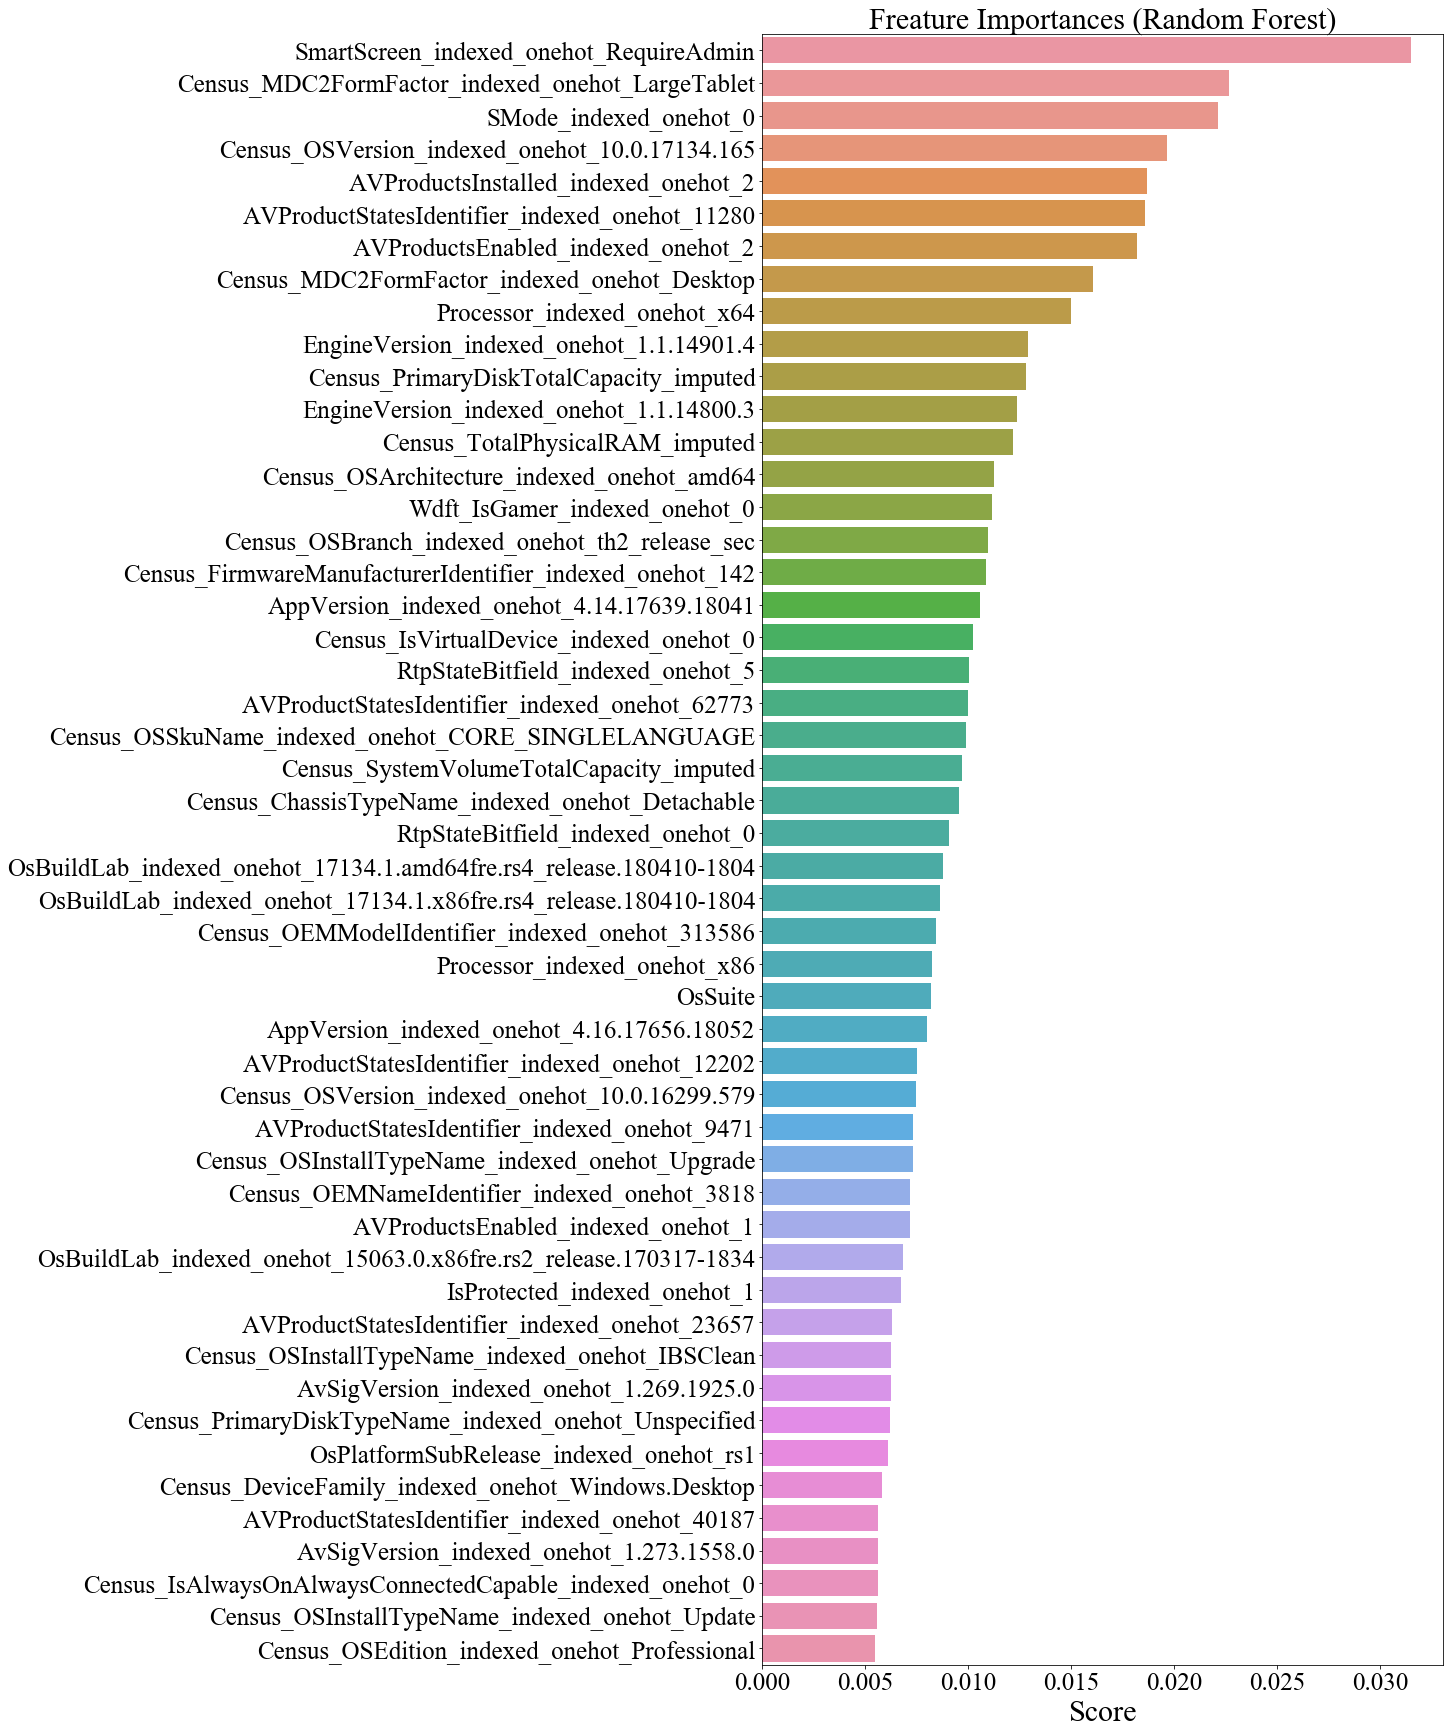

In [33]:
import seaborn as sbn
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12.2,30))

bar = sbn.barplot(x='score',y='name',data=rfFeatureImportance[:50])
bar.axes.set_title("Freature Importances (Random Forest)",fontsize=30)
bar.set_xlabel("Score",fontsize=30)
bar.set_ylabel("",fontsize=30)
bar.tick_params(labelsize=25)

#plt.tight_layout()
plt.savefig('rfFeatures.png')
plt.savefig('rfFeatures.pdf')

plt.show()


#### LightGBM

In [34]:
# the below command will produce some error messages; hence, I cannot get the feature importances of LightGBM
#gbcvmodeltiny.bestModel.getFeatureImportances(importance_type='split')

### 4.4 Predictions 

#### LightGBM

In [35]:
predict = gbcvmodeltiny.transform(mldata.select('features'))

In [36]:
predict.columns

['features', 'rawPrediction', 'probability', 'prediction']

In [37]:
mldata.select('MachineIdentifier','HasDetections','features')\
      .join(predict.select('features','prediction'),mldata.features==predict.features)\
      .show(5)

+--------------------+-------------+--------------------+--------------------+----------+
|   MachineIdentifier|HasDetections|            features|            features|prediction|
+--------------------+-------------+--------------------+--------------------+----------+
|fcd5c6286880e7c2c...|            0|(383217,[1,2,3,4,...|(383217,[1,2,3,4,...|       0.0|
|13bef61da72d32c0a...|            1|(383217,[1,2,3,4,...|(383217,[1,2,3,4,...|       0.0|
|152751f1f3e3b2e19...|            1|(383217,[1,2,3,4,...|(383217,[1,2,3,4,...|       1.0|
|8268fa3bb3b081e06...|            0|(383217,[1,2,3,4,...|(383217,[1,2,3,4,...|       0.0|
|01e8197a438925ccc...|            0|(383217,[1,2,3,4,...|(383217,[1,2,3,4,...|       0.0|
+--------------------+-------------+--------------------+--------------------+----------+
only showing top 5 rows



In [38]:
resultdf = \
mldata.select('MachineIdentifier','HasDetections','features')\
      .join(predict.select('features','prediction'),mldata.features==predict.features)

In [39]:
resultdf.cache()

DataFrame[MachineIdentifier: string, HasDetections: int, features: vector, features: vector, prediction: double]

In [40]:
resultdf.count()

8941311

In [41]:
resultdf.columns

['MachineIdentifier', 'HasDetections', 'features', 'features', 'prediction']

In [42]:
resultdf.crosstab('HasDetections','prediction').show()

+------------------------+-------+-------+
|HasDetections_prediction|    0.0|    1.0|
+------------------------+-------+-------+
|                       1|1624867|2839791|
|                       0|2873542|1603111|
+------------------------+-------+-------+



#### RandomForest

In [43]:
rfpredict = rfcvmodeltiny.transform(mldata.select('features'))

In [44]:
mldata.select('MachineIdentifier','HasDetections','features')\
      .join(rfpredict.select('features','prediction'),mldata.features==rfpredict.features)\
      .show(5)

+--------------------+-------------+--------------------+--------------------+----------+
|   MachineIdentifier|HasDetections|            features|            features|prediction|
+--------------------+-------------+--------------------+--------------------+----------+
|fcd5c6286880e7c2c...|            0|(383217,[1,2,3,4,...|(383217,[1,2,3,4,...|       0.0|
|13bef61da72d32c0a...|            1|(383217,[1,2,3,4,...|(383217,[1,2,3,4,...|       0.0|
|152751f1f3e3b2e19...|            1|(383217,[1,2,3,4,...|(383217,[1,2,3,4,...|       1.0|
|8268fa3bb3b081e06...|            0|(383217,[1,2,3,4,...|(383217,[1,2,3,4,...|       0.0|
|01e8197a438925ccc...|            0|(383217,[1,2,3,4,...|(383217,[1,2,3,4,...|       0.0|
+--------------------+-------------+--------------------+--------------------+----------+
only showing top 5 rows



In [45]:
rfresultdf = \
mldata.select('MachineIdentifier','HasDetections','features')\
      .join(rfpredict.select('features','prediction'),mldata.features==rfpredict.features)

In [46]:
rfresultdf.crosstab('HasDetections','prediction').show()

+------------------------+-------+-------+
|HasDetections_prediction|    0.0|    1.0|
+------------------------+-------+-------+
|                       1|1218044|3246614|
|                       0|1949609|2527044|
+------------------------+-------+-------+



#### Plot results

In [50]:
gbmresult = pd.DataFrame([[2873542,1603111],[1624867,2839791]],columns=['0','1'])
rfresult = pd.DataFrame([[1949609,2527044],[1218044,3246614]],columns=['0','1'])

In [61]:
gbmNorm = gbmresult.apply(lambda row: row/np.sum(row), axis=1)
rfNorm = rfresult.apply(lambda row: row/np.sum(row), axis=1)

In [62]:
gbmNorm

,0,1
0,0.641895,0.358105
1,0.363940,0.636060


In [63]:
rfNorm

,0,1
0,0.435506,0.564494
1,0.272819,0.727181


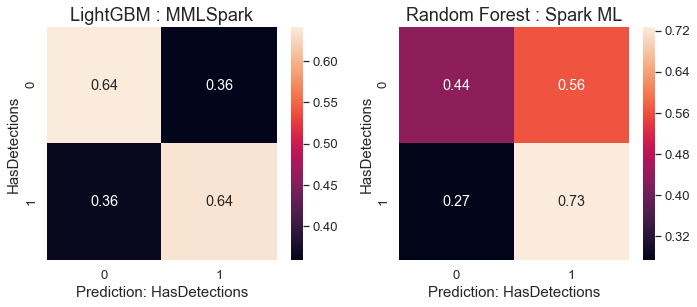

In [77]:
fig = plt.figure(figsize=(10,4.5))


sbn.set(font_scale=1.2)

plt.subplot(121)
hm = sbn.heatmap(gbmNorm, annot=True)
hm.axes.set_title("LightGBM : MMLSpark",fontsize=18)
hm.set_xlabel('Prediction: HasDetections',fontsize=15)
hm.set_ylabel('HasDetections',fontsize=15)



plt.subplot(122)
hm = sbn.heatmap(rfNorm, annot=True)
hm.axes.set_title("Random Forest : Spark ML",fontsize=18)
hm.set_xlabel('Prediction: HasDetections',fontsize=15)
hm.set_ylabel('HasDetections',fontsize=15)



#plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.tight_layout()
plt.savefig('result_ms.png')
plt.savefig('result_ms.pdf')

plt.show()